In [13]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt


2023-12-18 15:57:25.620202: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 15:57:25.809047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 15:57:25.809075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 15:57:25.840948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 15:57:25.908673: I tensorflow/core/platform/cpu_feature_guar

# Loading DF

In [14]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [15]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3373 non-null   object 
 1   Open       3373 non-null   float64
 2   High       3373 non-null   float64
 3   Low        3373 non-null   float64
 4   Close      3373 non-null   float64
 5   Adj Close  3373 non-null   float64
 6   Volume     3373 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 184.6+ KB


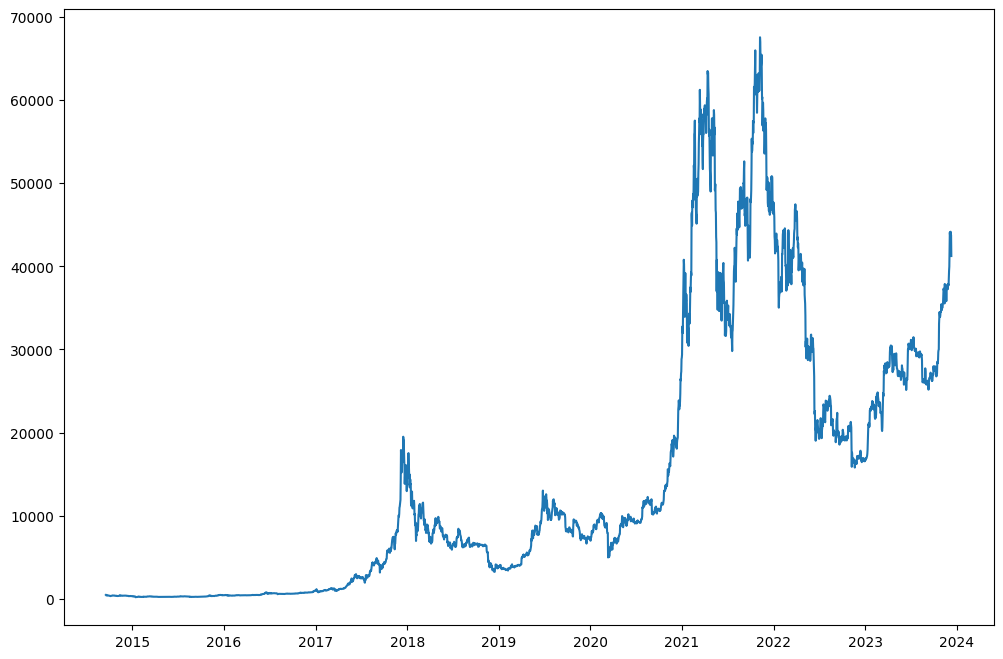

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,8))
plt.plot(df['Date'],df['Close'])

# Prepare Data

In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Close_normalized'] = scaler.fit_transform(df[['Close']])

In [19]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_normalized
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.004144
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0.003655
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0.003216
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.003425
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0.003275


In [20]:
pd.to_numeric(df['Date'])

0       1410912000000000000
1       1410998400000000000
2       1411084800000000000
3       1411171200000000000
4       1411257600000000000
               ...         
3368    1701907200000000000
3369    1701993600000000000
3370    1702080000000000000
3371    1702166400000000000
3372    1702252800000000000
Name: Date, Length: 3373, dtype: int64

In [21]:
timesteps = df['Date'].to_numpy()
prices = df['Close_normalized'].to_numpy()
timesteps[:5],prices[:5]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ]))

In [22]:
def create_train_test_split(timesteps,prices, test_size=0.2):
    split_size = int((1-test_size)*len(timesteps))
    X_train,X_test = timesteps[:split_size], timesteps[split_size:]
    y_train,y_test = prices[:split_size], prices[split_size:]
    return X_train,X_test,y_train,y_test

In [23]:
X_train,X_test,y_train,y_test = create_train_test_split(timesteps,prices)

In [24]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2698, 675, 2698, 675)

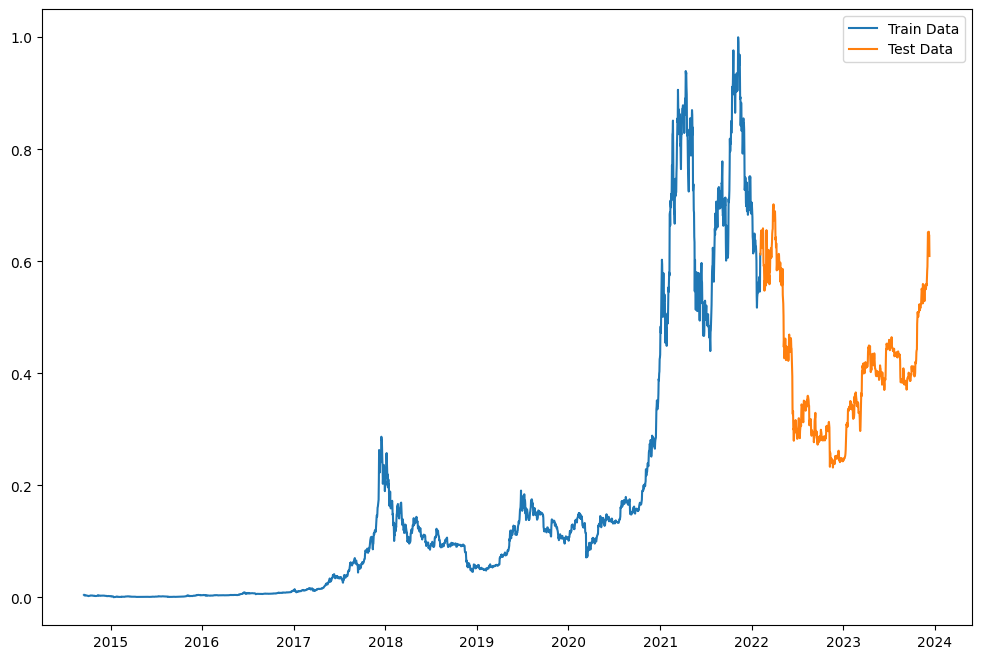

In [25]:
plt.figure(figsize=(12,8))
plt.plot(X_train,y_train, label='Train Data')
plt.plot(X_test,y_test, label='Test Data')
plt.legend();

In [26]:
model_0 = LinearRegression()
model_0.fit(pd.to_numeric(X_train).reshape(-1,1),y_train)

LinearRegression()

In [27]:
model_0_preds = model_0.predict(pd.to_numeric(X_test).reshape(-1,1))

In [28]:
mae = mean_absolute_error(y_test,model_0_preds)
mse = mean_squared_error(y_test,model_0_preds)
r2 = r2_score(y_test,model_0_preds)
mse,mae,r2

(0.037122876069701743, 0.18037522264784517, -1.8373096212999815)

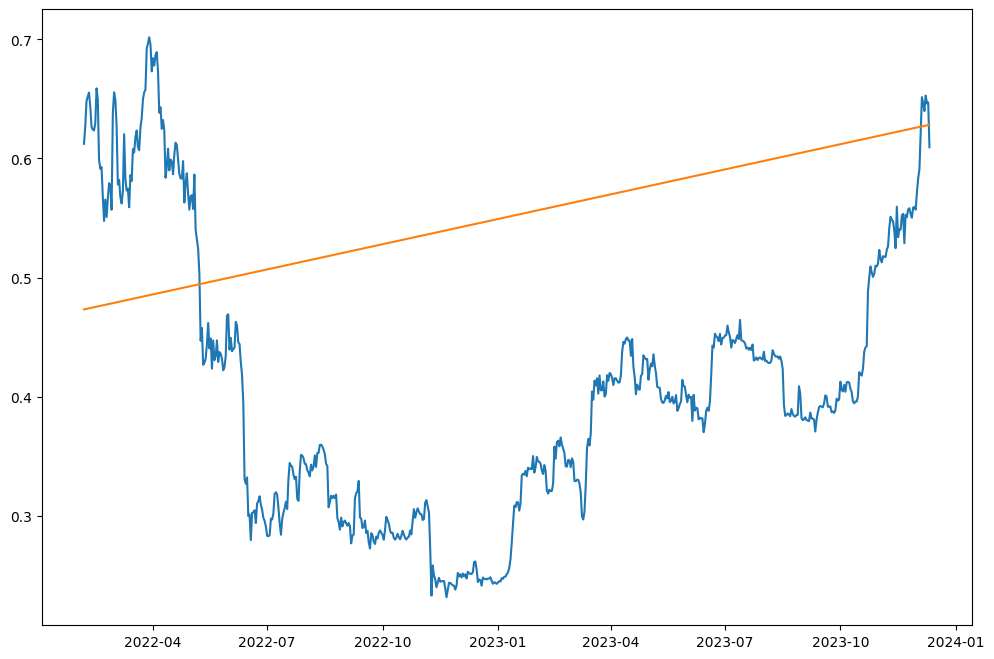

In [29]:
plt.figure(figsize=(12,8))
plt.plot(X_test,y_test, label='Actual Prices')
plt.plot(X_test,model_0_preds, label='Predicted Price')

# Windowing Dataset

In [61]:
WINDOW_SIZE = 30
HORIZON = 1

In [62]:
def get_label_windows(df, horizon=1):
    """
  Creates labels for windowed dataset.
    """
    return df[:,:-horizon], df[:,-horizon:]

In [63]:
test_window,test_label = get_label_windows(tf.expand_dims(tf.range(11),axis=0),horizon=1)
print(tf.squeeze(test_window).numpy), print(tf.squeeze(test_label))

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>>
tf.Tensor(10, shape=(), dtype=int32)


(None, None)

In [64]:
def make_windows(x, window_size, horizon):
    window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_index = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon-1)), axis=0).T 
    window_array = x[window_index]
    windows, labels = get_label_windows(window_array, horizon=horizon)
    return windows, labels

In [65]:
full_windows,full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows),len(full_labels)


(3343, 3343)

In [66]:
def make_train_test_splits(windows,labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [67]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2674, 2674, 669, 669)

In [68]:
train_windows.shape

(2674, 30)

In [69]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
model_1 = Sequential([
    tf.keras.layers.Input(WINDOW_SIZE),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    LSTM(128, activation='relu', return_sequences='same'),
    LSTM(128, activation='relu', return_sequences='same'),
    LSTM(512, activation='relu', return_sequences='same'),
    LSTM(128, activation='relu', return_sequences='same'),
    LSTM(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model_1.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model_1.fit(train_windows,train_labels,
           epochs=50,
           validation_data=(test_windows,test_labels),
           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)])

Epoch 1/50
84/84 [==============================] - 4s 21ms/step - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/50
84/84 [==============================] - 1s 16ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 8.8525e-04 - mse: 8.8525e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/50
84/84 [==============================] - 1s 16ms/step - loss: 6.3086e-04 - mse: 6.3086e-04 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/50
84/84 [==============================] - 1s 17ms/step - loss: 4.8434e-04 - mse: 4.8434e-04 - val_loss: 7.3249e-04 - val_mse: 7.3249e-04
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 4.9488e-04 - mse: 4.9488e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 8/50
84/84 [=========================

In [71]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
model_1_pred = tf.reshape(model_1_preds,(-1,1))

21/21 [==============================] - 0s 2ms/step


In [72]:
test_windows.shape

(669, 30)

In [73]:
mse = mean_squared_error(y_test,model_1_pred)
mse

ValueError: Found input variables with inconsistent numbers of samples: [675, 669]

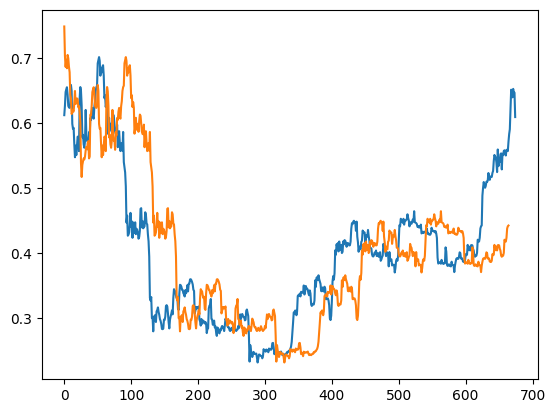

In [59]:
plt.plot(y_test)
plt.plot(test_windows)